# CASA0007 Major Assignment

## 1. Overview

### 1.1 Research question
How are levels of unment HIV pre-exposure prophylaxis (PrEP) need associated with regional characteristics in England?

### 1.2 Data Sources
1. UK Health Security Agency PrEP Tables, from the [National PrEP monitoring and evaluation framework](https://www.gov.uk/government/publications/hiv-pre-exposure-prophylaxis-prep-monitoring-and-evaluation)  
    - HIV PrEP Need  
    - HIV prevalence  
    - HIV new diagnosis rates  
2. ONS Census [Geographical Correspondence](https://www.ons.gov.uk/methodology/geography/ukgeographies/administrativegeography/england)
3. ONS Census Demographic Data, from [Nomis](https://www.nomisweb.co.uk/sources/census_2011_ks)  
    - Country of birth
    - Ethnicity
    - Religion
    - Population density
    - Living arrangements
    - Marriages/Civil partnerships
    - Sexuality & Gender Identity
    - Socioeconomic status
    - Years lived in the UK
4. Rural/Urban Population by Local Authority, from [Department for Environment, Food and Rural Affairs](https://www.gov.uk/government/statistics/2011-rural-urban-classification-of-local-authority-and-other-higher-level-geographies-for-statistical-purposes)

**Data still need to source:**
- Sexual health service funding by county
- Social attitudes by county (e.g. indicators of openness to LGBT community)


In [25]:
#Reading in libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from functools import reduce

In [35]:
# from skimpy import clean_columns

## 2. Data Preparation

### 2.1 Load data

**Geographic Correspondence File** *CAN DELETE??*

In [ ]:
# Read in correspondence data
correspondence = pd.read_csv('data/pcd_oa_lsoa_msoa_ltla_utla_rgn_ctry_ew_may_2021_lu_v2.csv',
                            dtype='str')

# correspondence.dtypes

In [ ]:
# correspondence.head(5)

**Urban Rural Classification**

In [70]:
ruralurban = clean_columns(pd.read_csv('data/rural_urban_county_classification.csv'))

# Select desired columns
ruralurban = ruralurban[["upper_tier_local_authority_area_2021_code", "rural_urban_classification_2011_6_fold", "rural_urban_classification_2011_3_fold"]]

# Rename columns
ruralurban.rename(columns = {"upper_tier_local_authority_area_2021_code":"mnemonic",
                             "rural_urban_classification_2011_6_fold":"ru_6fold",
                             "rural_urban_classification_2011_3_fold":"ru_3fold"},
                 inplace = True)

ruralurban

4 column names have been cleaned

,mnemonic,ru_6fold,ru_3fold
0,E06000011,Largely Rural,Predominantly Rural
1,E06000019,Largely Rural,Predominantly Rural
2,E06000047,Largely Rural,Predominantly Rural
3,E06000051,Largely Rural,Predominantly Rural
4,E06000054,Largely Rural,Predominantly Rural
...,...,...,...
147,E10000018,Urban with Significant Rural,Urban with Significant Rural
148,E10000024,Urban with Significant Rural,Urban with Significant Rural
149,E10000028,Urban with Significant Rural,Urban with Significant Rural
150,E10000031,Urban with Significant Rural,Urban with Significant Rural


**HIV Data: PrEP Need**

In [3]:
# Read in outcome (HIV and PrEP) data
hivprepneed = pd.read_csv('data/STI by county/hiv-prep-need.csv')

# hivprepneed.dtypes
#All fields read in as expected

# Remove first row (contains England total)
hivprepneed.drop(index = 0, inplace = True)

In [4]:
# hivprepneed.head(5)

In [5]:
# Read in HIV new diagnosis data
hivnewdiagnosis = pd.read_csv('data/STI by county/new-hiv-diagnosis.csv')

# Remove first row (contains England total)
hivnewdiagnosis.drop(index = 0, inplace = True)

# hivnewdiagnosis.head(5)

In [7]:
# Read in HIV PrEP use data
hivprepuse = pd.read_csv('data/STI by county/hiv-prep-use-by-need.csv')

# Remove first row (contains England total)
hivprepuse.drop(index = 0, inplace = True)

# hivprepuse.head(5)

In [8]:
# Read in HIV prevalence data
hivprevalence = pd.read_csv('data/STI by county/hiv-prevalence.csv')

# Remove first row (contains England total)
# hivprevalence.drop(index = 0, inplace = True)

# hivprevalence.head(5)

**Census Demographic Data**

In [19]:
# Read in predictor data (Census demographics)
cob = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/cob-detailed.csv'))

ethnicity = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/ethnicity.csv'))

genderidentity = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/gender-identity.csv'))

highested = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/highest-qualification.csv'))

# hhdep = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/household-deprivation.csv'))

partners = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/legal-partnership.csv'))

sexuality = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/sexuality.csv'))

religion = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/religion.csv'))

# nssec = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/ns-sec.csv'))

popdens = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/popuation-density.csv'))

# lengthinuk = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/length-of-residence.csv'))

34 column names have been cleaned

8 column names have been cleaned

8 column names have been cleaned

9 column names have been cleaned

7 column names have been cleaned

11 column names have been cleaned

10 column names have been cleaned

11 column names have been cleaned

1 column names have been cleaned

11 column names have been cleaned

7 column names have been cleaned

In [43]:
# (i) COUNTRY OF BIRTH

cob = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/cob-detailed.csv', 
                                nrows = 152)  # read only the 152 English LAs; leave out footer text
                   )

# Clean columns
# cob.dtypes

cob["cob_non_uk_pc"] = 100 - cob["%"]
cob["cob_africa_all"] = cob.africa_north_africa + cob.africa_central_and_western_africa + cob.africa_south_and_eastern_africa + cob.africa_africa_not_otherwise_specified
cob["cob_africa_all_pc"] = cob["%_2"] + cob["%_3"] + cob["%_4"] + cob["%_5"]

cob.rename(columns = {"%":"cob_uk_pc"}, inplace = True)

# Select desired columns
cob = cob[["mnemonic", "cob_uk_pc", "cob_non_uk_pc", "cob_africa_all_pc"]]

cob

34 column names have been cleaned

,mnemonic,cob_uk_pc,cob_non_uk_pc,cob_africa_all_pc
0,E06000005,92.2,7.8,0.7
1,E06000047,95.6,4.4,0.5
2,E06000001,96.0,4.0,0.5
3,E06000002,87.7,12.3,2.3
4,E06000057,96.5,3.5,0.4
...,...,...,...,...
147,E06000054,90.1,9.9,1.4
148,E10000008,92.9,7.1,0.9
149,E06000059,93.5,6.5,1.0
150,E10000013,90.0,10.0,1.4


In [50]:
# (ii) ETHNICITY 
ethnicity = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/ethnicity.csv', 
                                nrows = 152)  # read only the 152 English LAs; leave out footer text
                   )

# Clean columns
ethnicity.dtypes

ethnicity["non_white"] = ethnicity.total_all_usual_residents - ethnicity.white
ethnicity["white_pc"] = round(ethnicity.white/ethnicity.total_all_usual_residents*100, 2)
ethnicity["non_white_pc"] = round(ethnicity.non_white/ethnicity.total_all_usual_residents*100, 2)
ethnicity["black_british_pc"] = round(
    (ethnicity.black_black_british_black_welsh_of_african_background + ethnicity.black_black_british_black_welsh_or_caribbean_background)/
    ethnicity.total_all_usual_residents*100, 2
  )

# Select desired columns
ethnicity = ethnicity[["mnemonic", "white_pc", "non_white_pc", "black_british_pc"]]

ethnicity


8 column names have been cleaned

,mnemonic,white_pc,non_white_pc,black_british_pc
0,E06000005,94.37,5.63,0.65
1,E06000047,96.82,3.18,0.33
2,E06000001,96.46,3.54,0.48
3,E06000002,82.37,17.63,2.65
4,E06000057,97.65,2.35,0.19
...,...,...,...,...
147,E06000054,94.33,5.67,1.13
148,E10000008,96.40,3.60,0.30
149,E06000059,97.06,2.94,0.28
150,E10000013,93.06,6.94,1.20


In [51]:
# (iii) GENDER IDENTITY
genderidentity = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/gender-identity.csv', 
                                nrows = 152)  # read only the 152 English LAs; leave out footer text
                   )

# Clean columns
# genderidentity.dtypes

genderidentity["non_cis_pc"] = round((genderidentity.gender_identity_different_from_sex_registered_at_birth_but_no_specific_identity_given +
                                     genderidentity.trans_woman +
                                     genderidentity.trans_man +
                                     genderidentity.all_other_gender_identities) /
                                     genderidentity.total_all_usual_residents_aged_16_years_and_over*100,
                                     2
                                    )
genderidentity["cis_pc"] = round(genderidentity.gender_identity_the_same_as_sex_registered_at_birth /
                                 genderidentity.total_all_usual_residents_aged_16_years_and_over*100,
                                 2
                                )

# Select desired columns
genderidentity = genderidentity[["mnemonic", "cis_pc", "non_cis_pc"]]

genderidentity

8 column names have been cleaned

,mnemonic,cis_pc,non_cis_pc
0,E06000005,95.09,0.42
1,E06000047,95.07,0.37
2,E06000001,94.51,0.43
3,E06000002,93.04,0.82
4,E06000057,95.48,0.27
...,...,...,...
147,E06000054,94.73,0.35
148,E10000008,94.02,0.34
149,E06000059,94.34,0.27
150,E10000013,94.39,0.41


In [55]:
# (iv) HIGHEST QUALIFICATION
highested = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/highest-qualification.csv', 
                                nrows = 152)  # read only the 152 English LAs; leave out footer text
                   )

# Clean columns
# highested.dtypes

highested["tertiary_ed_pc"] = round(highested.level_4_qualifications_and_above / highested.total_all_usual_residents_aged_16_years_and_over*100, 2)

# Select desired columns
highested = highested[["mnemonic", "tertiary_ed_pc"]]

highested

9 column names have been cleaned

,mnemonic,tertiary_ed_pc
0,E06000005,28.96
1,E06000047,26.74
2,E06000001,24.81
3,E06000002,26.44
4,E06000057,30.74
...,...,...
147,E06000054,34.17
148,E10000008,32.87
149,E06000059,31.47
150,E10000013,35.62


In [58]:
# (v) LEGAL PARTNERSHIP
partners = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/legal-partnership.csv', 
                                nrows = 152)  # read only the 152 English LAs; leave out footer text
                   )

# Clean columns
partners.dtypes

partners["same_sex_partnership_pc"] = round(
    (partners.married_or_in_a_registered_civil_partnership_married_same_sex + partners.married_or_in_a_registered_civil_partnership_in_a_registered_civil_partnership_same_sex) /
    partners.total_all_usual_residents_aged_16_and_over*100,
    2 )

# Select desired columns
partners = partners[["mnemonic", "same_sex_partnership_pc"]]

partners


11 column names have been cleaned

,mnemonic,same_sex_partnership_pc
0,E06000005,0.37
1,E06000047,0.33
2,E06000001,0.34
3,E06000002,0.31
4,E06000057,0.36
...,...,...
147,E06000054,0.37
148,E10000008,0.41
149,E06000059,0.40
150,E10000013,0.39


In [60]:
# (vi) SEXUALITY
sexuality = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/sexuality.csv', 
                                nrows = 152)  # read only the 152 English LAs; leave out footer text
                   )

# Clean columns
# sexuality.dtypes

sexuality["non_hetero_pc"] = round(
    (sexuality.total_all_usual_residents_aged_16_years_and_over - sexuality.straight_or_heterosexual) / 
    sexuality.total_all_usual_residents_aged_16_years_and_over * 100,
    2 )

# Select desired columns
sexuality = sexuality[["mnemonic", "non_hetero_pc"]]

sexuality

7 column names have been cleaned

,mnemonic,non_hetero_pc
0,E06000005,8.58
1,E06000047,8.62
2,E06000001,8.86
3,E06000002,10.45
4,E06000057,7.89
...,...,...
147,E06000054,9.06
148,E10000008,10.39
149,E06000059,9.38
150,E10000013,9.60


In [62]:
# (vii) RELIGION
religion = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/religion.csv', 
                                nrows = 152)  # read only the 152 English LAs; leave out footer text
                   )

# Clean columns
# religion.dtypes

religion["religious_pc"] = round(
    (religion.total_all_usual_residents - religion.no_religion) / religion.total_all_usual_residents * 100,
    2 )

# Select desired columns
religion = religion[["mnemonic", "religious_pc"]]

religion

11 column names have been cleaned

,mnemonic,religious_pc
0,E06000005,60.32
1,E06000047,61.37
2,E06000001,59.94
3,E06000002,63.58
4,E06000057,59.85
...,...,...
147,E06000054,58.73
148,E10000008,55.51
149,E06000059,59.89
150,E10000013,58.62


In [64]:
# (viii) POPULATION DENSITY
popdens = clean_columns(pd.read_csv('data/Census by county/census-2021-clean/popuation-density.csv', 
                                nrows = 152)  # read only the 152 English LAs; leave out footer text
                   )

# Rename column
popdens.rename(columns = {"2021":"pop_density"}, inplace = True)

popdens

1 column names have been cleaned

,2022_local_authorities_county,mnemonic,pop_density
0,Darlington,E06000005,545.9
1,County Durham,E06000047,234.5
2,Hartlepool,E06000001,985.5
3,Middlesbrough,E06000002,2671.2
4,Northumberland,E06000057,63.9
...,...,...,...
147,Wiltshire,E06000054,156.8
148,Devon,E10000008,123.7
149,Dorset,E06000059,152.4
150,Gloucestershire,E10000013,243.2


### 2.2 Merge dataframes

**List of census dataframes to merge:**

1. cob
2. ethnicity
3. genderidentity
4. highested
5. partners
6. sexuality
7. religion
8. popdens

In [72]:
# Initialise dataframe
census_dfs = []

# Add cob
census_dfs = pd.merge(left = popdens, right = cob, on = "mnemonic", how = "inner")

# Add ethnicity
census_dfs = pd.merge(left = census_dfs, right = ethnicity, on = "mnemonic", how = "inner")

# Add genderidentity
census_dfs = pd.merge(left = census_dfs, right = genderidentity, on = "mnemonic", how = "inner")

# Add highested
census_dfs = pd.merge(left = census_dfs, right = highested, on = "mnemonic", how = "inner")

# Add partners
census_dfs = pd.merge(left = census_dfs, right = partners, on = "mnemonic", how = "inner")

# Add sexuality
census_dfs = pd.merge(left = census_dfs, right = sexuality, on = "mnemonic", how = "inner")

# Add religion
census_dfs = pd.merge(left = census_dfs, right = religion, on = "mnemonic", how = "inner")

# census_dfs

**Urban Rural Classification**

In [73]:
census_dfs = pd.merge(left = census_dfs, right = ruralurban, on = "mnemonic", how = "inner")

census_dfs

,2022_local_authorities_county,mnemonic,pop_density,cob_uk_pc,cob_non_uk_pc,cob_africa_all_pc,white_pc,non_white_pc,black_british_pc,cis_pc,non_cis_pc,tertiary_ed_pc,same_sex_partnership_pc,non_hetero_pc,religious_pc,ru_6fold,ru_3fold
0,Darlington,E06000005,545.9,92.2,7.8,0.7,94.37,5.63,0.65,95.09,0.42,28.96,0.37,8.58,60.32,Urban with City and Town,Predominantly Urban
1,County Durham,E06000047,234.5,95.6,4.4,0.5,96.82,3.18,0.33,95.07,0.37,26.74,0.33,8.62,61.37,Largely Rural,Predominantly Rural
2,Hartlepool,E06000001,985.5,96.0,4.0,0.5,96.46,3.54,0.48,94.51,0.43,24.81,0.34,8.86,59.94,Urban with City and Town,Predominantly Urban
3,Middlesbrough,E06000002,2671.2,87.7,12.3,2.3,82.37,17.63,2.65,93.04,0.82,26.44,0.31,10.45,63.58,Urban with City and Town,Predominantly Urban
4,Northumberland,E06000057,63.9,96.5,3.5,0.4,97.65,2.35,0.19,95.48,0.27,30.74,0.36,7.89,59.85,Largely Rural,Predominantly Rural
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,Wiltshire,E06000054,156.8,90.1,9.9,1.4,94.33,5.67,1.13,94.73,0.35,34.17,0.37,9.06,58.73,Largely Rural,Predominantly Rural
148,Devon,E10000008,123.7,92.9,7.1,0.9,96.40,3.60,0.30,94.02,0.34,32.87,0.41,10.39,55.51,Largely Rural,Predominantly Rural
149,Dorset,E06000059,152.4,93.5,6.5,1.0,97.06,2.94,0.28,94.34,0.27,31.47,0.40,9.38,59.89,Largely Rural,Predominantly Rural
150,Gloucestershire,E10000013,243.2,90.0,10.0,1.4,93.06,6.94,1.20,94.39,0.41,35.62,0.39,9.60,58.62,Urban with Significant Rural,Urban with Significant Rural


### 2.2 Descriptive statistics

In [13]:
# hivprepneed.describe()

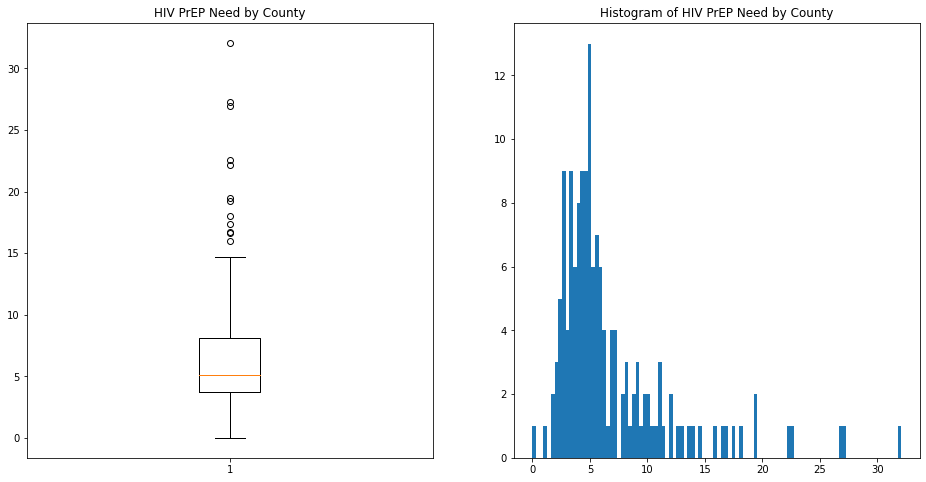

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
ax1.boxplot(hivprepneed.Value,
           vert = True)
ax1.set_title("HIV PrEP Need by County")
ax2.hist(hivprepneed.Value,
        bins = 100)
ax2.set_title("Histogram of HIV PrEP Need by County")
plt.show()

Reading the figure above, PrEP need is skewed towards the right, with a small handful of counties having much higher rates compared with the mean and median values.   
**Q:** Is this skew too extreme to meet the assumptions for a normal distribution? Should a transformation be applied or outliers removed?  
**A:** Should avoid removing outliers as in this case they are likely very important to the underlying processes (e.g. the social factors which will be examined as predictors are likely part of the reason for these extreme values, not a random or unexpected oddity).  
Could use a normalisation/standardisation method to reduce the skew? (Or will this just reduce the magnitude of variation?)

**Predictor Variables**